In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import random

In [2]:
df = pd.read_csv('auto_insurance_csv.csv')
df.head()

,Unnamed: 0,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,0,328,48.0,521585,2014-10-17,OH,250/500,1000,1406.91,0.0,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,1,228,42.0,342868,2006-06-27,IN,250/500,2000,1197.22,5000000.0,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,2,134,29.0,687698,2000-09-06,OH,NaN,2000,1413.14,5000000.0,...,NaN,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,3,256,41.0,227811,1990-05-25,IL,NaN,2000,1415.74,6000000.0,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,4,228,44.0,367455,2014-06-06,IL,NaN,1000,1583.91,6000000.0,...,NaN,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [3]:
# removing column named _c39 as it contains only null values

df = df.drop(['_c39','Unnamed: 0'], axis = 1)

In [4]:
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df.groupby(['umbrella_limit']).agg({'policy_number': 'count'})

,policy_number
umbrella_limit,
-1000000.0,1
0.0,640
2000000.0,3
3000000.0,7
4000000.0,33
5000000.0,35
6000000.0,45
7000000.0,27
8000000.0,6


In [5]:
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df.groupby(['police_report_available']).agg({'policy_number': 'count'})


,policy_number
police_report_available,
?,257
MISSING,250
NO,262
YES,231


In [6]:
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df.groupby(['policy_csl']).agg({'policy_number': 'count'})


,policy_number
policy_csl,
100/300,44
250/500,43
500/1000,40
MISSING,873


In [7]:
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days


In [8]:
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)

In [9]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, ":", df[i].nunique())

policy_state : 3
policy_csl : 4
umbrella_limit : 11
insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 20
insured_relationship : 6
incident_type : 4
collision_type : 4
incident_severity : 4
authorities_contacted : 5
incident_state : 7
incident_city : 7
incident_location : 1000
property_damage : 3
police_report_available : 4
auto_make : 14
auto_model : 39
fraud_reported : 2


In [10]:
df = df.drop(['policy_bind_date','incident_date'],axis=1)

In [11]:
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)

In [12]:
df['umbrella_limit'] = df.umbrella_limit.astype(str)


In [13]:
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')

df['umbrella_limit'].unique()

C:\Users\bilal\AppData\Local\Temp/ipykernel_11188/3037549493.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')


array(['0.0', 'other', '9999'], dtype=object)

In [14]:
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['insured_hobbies'].unique()

array(['other', 'chess', 'cross-fit'], dtype=object)

In [15]:
df['age'] = df.age.fillna(9999)

In [16]:
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)

In [17]:
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)

In [18]:
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)

In [19]:
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)



In [20]:
#removing columns for which we created groups
df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
df.columns

Index(['policy_number', 'policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group'],
      dtype='object')

In [21]:
required_columns = ['policy_number', 'policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']

print(len(required_columns))
print(len(df.columns))

39
39


In [22]:
df1 = df[required_columns]

corr_matrix = df1.corr()



Keeping only the `total_claim_amount` column from these.

In [23]:
required_columns = ['policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']

print(len(required_columns))

35


In [24]:
df1 = df1[required_columns]
df1.head()

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
0,OH,250/500,0.0,466132,MALE,MD,craft-repair,other,husband,53300,...,Saab,92x,2004,1,100,False,46-50,301-350,medium,501-1000
1,IN,250/500,other,468176,MALE,MD,machine-op-inspct,other,other-relative,0,...,Mercedes,E400,2007,1,3130,False,41-45,201-250,medium,1501-2000
2,OH,MISSING,other,430632,FEMALE,PhD,sales,other,own-child,35100,...,Dodge,RAM,2007,0,5282,False,26-30,101-150,medium,1501-2000
3,IL,MISSING,other,608117,FEMALE,PhD,armed-forces,other,unmarried,48900,...,Chevrolet,Tahoe,2014,1,8996,False,41-45,251-300,medium,1501-2000
4,IL,MISSING,other,610706,MALE,Associate,sales,other,unmarried,66000,...,Accura,RSX,2009,0,256,False,41-45,201-250,high,501-1000


## Encoding data for modelling

In [25]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1[col] = df1[col].astype('object')

columns_to_encode = []
for col in df1.columns:
  if df1[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode

['policy_state',
 'policy_csl',
 'umbrella_limit',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'incident_location',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'location_check',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups',
 'policy_deductable_group']

---------------------------

### Buraya kadar olan kisimlar original notebookta olan verionisleme asamalari idi, buradan sonrasi kendi yorumum

In [31]:
y = df1['fraud_reported']
X = df1.drop(['fraud_reported'], axis=1)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [87]:
all_noncat = list(df1.columns)
for i in columns_to_encode:
    all_noncat.remove(i)
all_noncat.remove('fraud_reported')
all_noncat

['insured_zip',
 'capital-gains',
 'capital-loss',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'total_claim_amount',
 'auto_year',
 'claim_day_of_policy']

In [88]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(handle_unknown='ignore')

X_train_encoded = oh_encoder.fit_transform(X_train[columns_to_encode]).toarray()

X_test_encoded = oh_encoder.transform(X_test[columns_to_encode]).toarray()

In [89]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns=oh_encoder.get_feature_names())
X_test_encoded = pd.DataFrame(X_test_encoded, columns=oh_encoder.get_feature_names())

In [90]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[all_noncat])
X_test_scaled = scaler.transform(X_test[all_noncat])

In [91]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train[all_noncat].columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test[all_noncat].columns)

In [93]:
X_train = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_test = pd.concat([X_test_scaled, X_test_encoded], axis=1)

In [94]:
from sklearn.ensemble import RandomForestClassifier

## Random Forest

In [95]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

72.72727272727273

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       242
           1       0.45      0.10      0.17        88

    accuracy                           0.73       330
   macro avg       0.60      0.53      0.50       330
weighted avg       0.67      0.73      0.66       330



<AxesSubplot:>

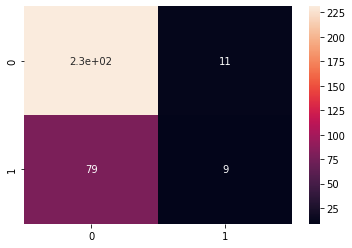

In [96]:
preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

# Hyperparameter Tuning

In SVC, we can change the kernel and degree inorder to improve our model. We will do that & see if accuracy improves.

In [97]:

from pprint import pprint
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


* n_estimators = Ağaç Sayısı
* max_features = Bir Node'u bölmek için kullanılacak maksimum feature sayısı
* max_depth = Her bir karar ağacının maksiumum leveli
* min_samples_split = Bir Node'u bölmeden önce kullanılacak minimum nokta sayısı
* min_samples_leaf =Bir Leaf Node'da izin verilen minimum nokta sayısı
* bootstrap = Veri noktalarını örnekleme yöntemi

In [98]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 17, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [300, 650, 1000]}


In [99]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 17, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 650, 1000]},
                   random_state=42, verbose=2)

In [100]:
rf_random.best_params_

{'n_estimators': 650,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

73.63636363636363

              precision    recall  f1-score   support

           0       0.75      0.97      0.84       242
           1       0.53      0.10      0.17        88

    accuracy                           0.74       330
   macro avg       0.64      0.53      0.51       330
weighted avg       0.69      0.74      0.66       330



<AxesSubplot:>

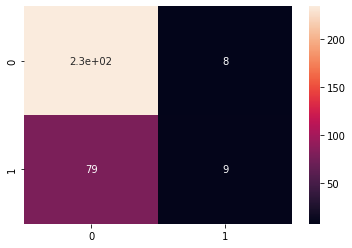

In [101]:
rf2 = RandomForestClassifier(n_estimators=650,min_samples_split=2,min_samples_leaf=1,max_features='sqrt'
                            ,max_depth=30,bootstrap='False')
rf2.fit(X_train, y_train)

preds = rf2.predict(X_test)

score = rf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

## Thresholdu degistirerek Fraudlarin daha iyi yakalanabildigi durumlari olusturdum buradan sonrasinda

In [111]:
preds_06_threshold = pd.DataFrame(rf2.predict_proba(X_test))[0].apply(lambda x: 0 if x>0.6 else 1)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       242
           1       0.64      0.61      0.62        88

    accuracy                           0.80       330
   macro avg       0.75      0.74      0.75       330
weighted avg       0.80      0.80      0.80       330



<AxesSubplot:>

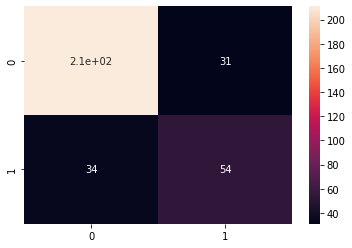

In [112]:

print(classification_report(y_test, preds_06_threshold))

cm = confusion_matrix(y_test, preds_06_threshold)
sns
sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       242
           1       0.65      0.83      0.73        88

    accuracy                           0.83       330
   macro avg       0.79      0.83      0.80       330
weighted avg       0.85      0.83      0.84       330



<AxesSubplot:>

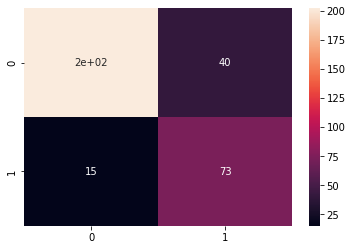

In [113]:
preds_07_threshold = pd.DataFrame(rf2.predict_proba(X_test))[0].apply(lambda x: 0 if x>0.7 else 1)


print(classification_report(y_test, preds_07_threshold))

cm = confusion_matrix(y_test, preds_07_threshold)
sns
sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       242
           1       0.59      0.86      0.70        88

    accuracy                           0.81       330
   macro avg       0.77      0.82      0.78       330
weighted avg       0.85      0.81      0.82       330



<AxesSubplot:>

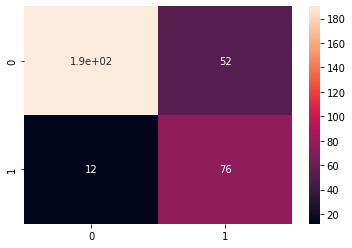

In [114]:
preds_08_threshold = pd.DataFrame(rf2.predict_proba(X_test))[0].apply(lambda x: 0 if x>0.8 else 1)


print(classification_report(y_test, preds_08_threshold))

cm = confusion_matrix(y_test, preds_08_threshold)
sns
sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       242
           1       0.64      0.85      0.73        88

    accuracy                           0.83       330
   macro avg       0.79      0.84      0.81       330
weighted avg       0.86      0.83      0.84       330



<AxesSubplot:>

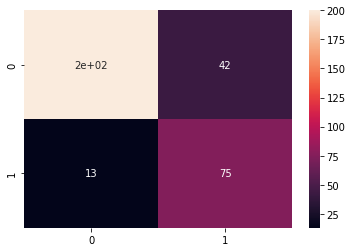

In [115]:
preds_075_threshold = pd.DataFrame(rf2.predict_proba(X_test))[0].apply(lambda x: 0 if x>0.75 else 1)


print(classification_report(y_test, preds_075_threshold))

cm = confusion_matrix(y_test, preds_075_threshold)
sns
sns.heatmap(cm, annot=True)